In [1]:
from pathlib import Path
import os

from eolearn.core import EOPatch

import matplotlib.pyplot as plt

import numpy as np
from numpy.random import default_rng
import pandas as pd
# import seaborn as sn

from sklearn.ensemble import RandomForestClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

import joblib

In [31]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 1.4 MB/s            


In [2]:
base_path = Path('/home/AOIs/polyphytos/young_research_data/S2L2A_20211219_train')

In [3]:
# feature_list = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']#, 'NDVI', 'NDBI', 'VIBI']
eop = EOPatch.load(base_path)
feature_list = eop.meta_info['band_names']
eop

EOPatch(
  data: {}
  mask: {}
  scalar: {
    muddy: numpy.ndarray(shape=(15575, 10), dtype=float32)
    non_muddy: numpy.ndarray(shape=(82462, 10), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    band_names: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    bands: 10
    height: 2185
    muddy: 1
    non_muddy: 0
    time: 1
    width: 2439
  }
  bbox: None
  timestamp: []
)

In [4]:
#--- Subsample manually
rng = default_rng(seed=42)
eop.scalar['non_muddy'] = rng.choice(eop.scalar['non_muddy'], size=round(eop.scalar['non_muddy'].shape[0]*0.19), replace=False)
eop.scalar['muddy'].shape, eop.scalar['non_muddy'].shape

((15575, 10), (15668, 10))

In [5]:
y = np.concatenate((np.ones(eop.scalar['muddy'].shape[0]), np.zeros(eop.scalar['non_muddy'].shape[0])))
x = np.concatenate((eop.scalar['muddy'], eop.scalar['non_muddy']), axis=0)
del eop
y.shape, x.shape

((31243,), (31243, 10))

In [6]:
# # Remove NDVI, NDBI, VIBI
# x = x[:, :-3]
# x.shape

In [7]:
# enc = OneHotEncoder(handle_unknown='ignore')
# y = enc.fit_transform(y.reshape(-1, 1)).toarray()

In [8]:
# Using Skicit-learn to split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (24994, 10)
Training Labels Shape: (24994,)
Testing Features Shape: (6249, 10)
Testing Labels Shape: (6249,)


In [ ]:
# Grid Search
parameters = {'n_estimators': [2, 3, 4, 5, 6, 7, 10, 50, 100],#8, 10],# 20, 50, 80],#, 250, 500, 750],
              'max_depth': [2, 3, 4, 5, 6, 8,10, 20, 30, 60, 100],
              'class_weight': ('balanced_subsample', 'balanced', None)
             }
clf = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

model = GridSearchCV(clf, parameters, scoring='f1', n_jobs=-1, cv=cv, verbose=1)
model.fit(x_train, y_train)

In [53]:
model.best_params_

{'class_weight': 'balanced_subsample', 'max_depth': 2, 'n_estimators': 10}

In [32]:
# Save grid search results
pd.DataFrame(model.cv_results_).to_excel('/home/AOIs/polyphytos/rf_grid_search.xlsx')

In [35]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, x_train, y_train, scoring='f1', cv=cv, n_jobs=-1, error_score='raise', verbose=1)
# report performance
print('F1 score: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.7min


F1 score: 1.000 (0.000)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


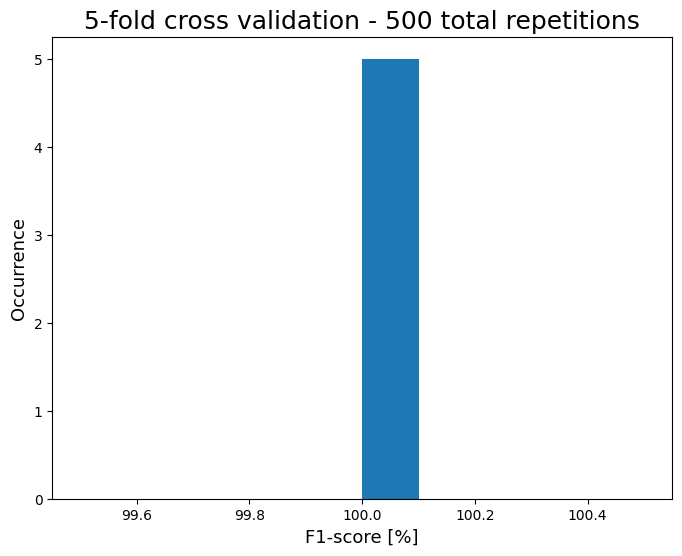

In [36]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))
p = ax.hist(n_scores*100, bins=10);
ax.set_title('5-fold cross validation - 500 total repetitions', fontsize=18);
ax.set_ylabel('Occurrence', fontsize=15)
ax.set_xlabel('F1-score [%]', fontsize=15)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)
# ax.tick_params(axis='both', labelsize=13)
# fig.savefig('/home/data/mydata/L2/f1_score_average.png', dpi=300, bbox_inches='tight')

In [146]:
# metrics.get_scorer_names()

In [37]:
# Fit model
model.fit(x_train, y_train);
# Use the forest's predict method on the test data
y_train_hat = model.predict_proba(x_train)
y_test_hat = model.predict_proba(x_test)

Fitting 15 folds for each of 105 candidates, totalling 1575 fits


In [38]:
print(metrics.confusion_matrix(y_test, np.argmax(y_test_hat, axis=1)))

[[3095    1]
 [   0 3153]]


In [39]:
print(metrics.classification_report(y_test, np.argmax(y_test_hat, axis=1)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3096
         1.0       1.00      1.00      1.00      3153

    accuracy                           1.00      6249
   macro avg       1.00      1.00      1.00      6249
weighted avg       1.00      1.00      1.00      6249



In [40]:
print('--- Test set ---')
print('Accuracy score:', metrics.accuracy_score(y_test, np.argmax(y_test_hat, axis=1)))
print('Precision score:', metrics.precision_score(y_test, np.argmax(y_test_hat, axis=1)))
print('Recall score:', metrics.recall_score(y_test, np.argmax(y_test_hat, axis=1)))
print('F1 score:', metrics.f1_score(y_test, np.argmax(y_test_hat, axis=1)))
print('ROC-AUC score:', metrics.roc_auc_score(y_test, np.argmax(y_test_hat, axis=1)))
print('\n')
print('--- Train set ---')
print('Accuracy score:', metrics.accuracy_score(y_train, np.argmax(y_train_hat, axis=1)))
print('Precision score:', metrics.precision_score(y_train, np.argmax(y_train_hat, axis=1)))
print('Recall score:', metrics.recall_score(y_train, np.argmax(y_train_hat, axis=1)))
print('F1 score:', metrics.f1_score(y_train, np.argmax(y_train_hat, axis=1)))
print('ROC-AUC score:', metrics.roc_auc_score(y_train, np.argmax(y_train_hat, axis=1)))

--- Test set ---
Accuracy score: 0.9998399743959033
Precision score: 0.9996829422954978
Recall score: 1.0
F1 score: 0.9998414460123672
ROC-AUC score: 0.9998385012919896


--- Train set ---
Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0
ROC-AUC score: 1.0


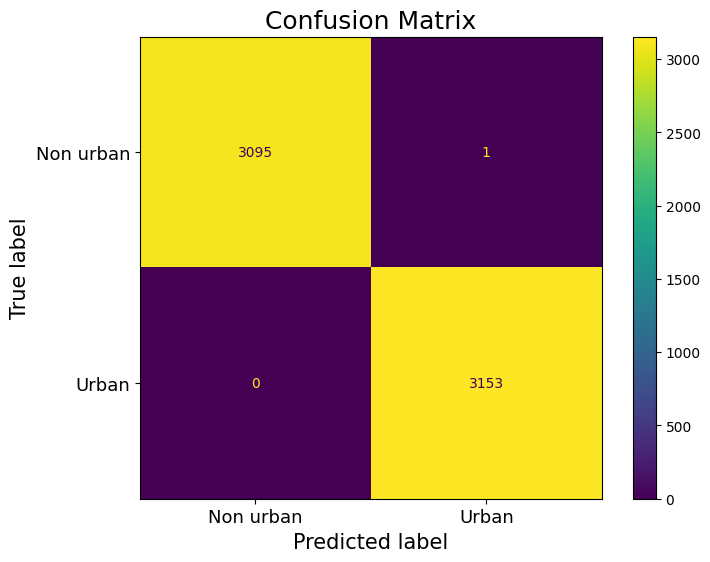

In [41]:
# plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))
# Confusion matrix
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_hat, axis=1), labels=[0, 1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=['Non urban', 'Urban'])
disp.plot(ax=ax);
ax.set_title('Confusion Matrix', fontsize=18);
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=13)
fig.savefig('/home/AOIs/polyphytos/confusion_matrix.png', dpi=200, bbox_inches='tight')

In [19]:
plt.style.use('fivethirtyeight') # list of x locations for plotting

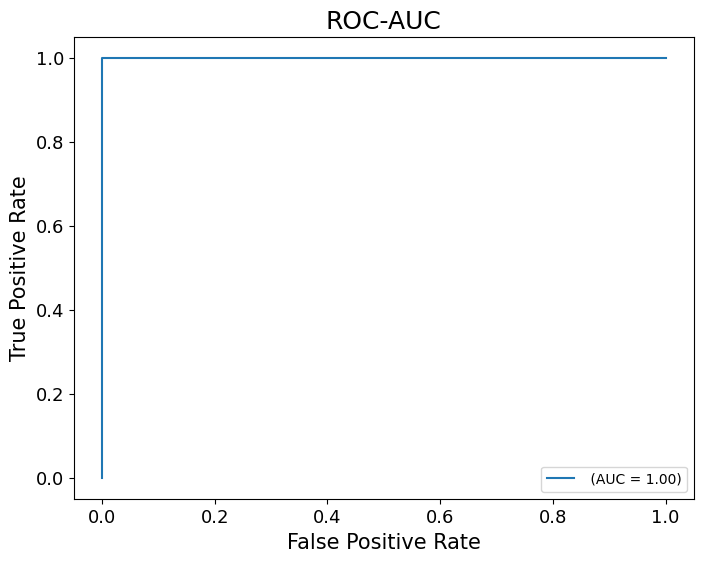

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_hat[:, 1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                          estimator_name='')
display.plot(ax=ax)
ax.set_title('ROC-AUC', fontsize=18);
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=13)
# fig.savefig('/home/data/mydata/L2/roc_auc.png', dpi=300, bbox_inches='tight')

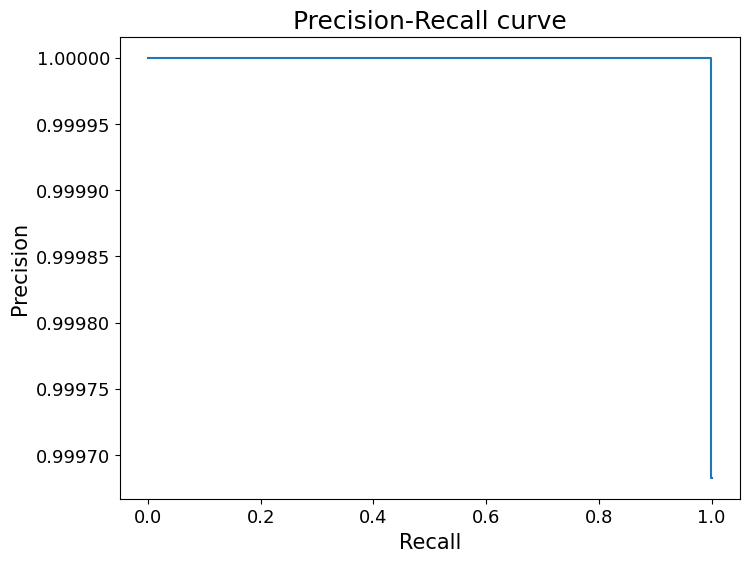

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
precision, recall, _ = metrics.precision_recall_curve(y_test, y_test_hat[:, 1])
display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot(ax=ax)
ax.set_title('Precision-Recall curve', fontsize=18);
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', labelsize=13)
# fig.savefig('/home/data/mydata/L2/precision_recall_curve.png', dpi=300, bbox_inches='tight')

#### Feature Importances

In [9]:
# Instantiate model with 1000 decision trees
model = RandomForestClassifier(**{'class_weight': 'balanced_subsample', 'max_depth': 2, 'n_estimators': 10, 'bootstrap': True})
model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=2,
                       n_estimators=10)

In [14]:
y_train_hat = model.predict_proba(x_train)

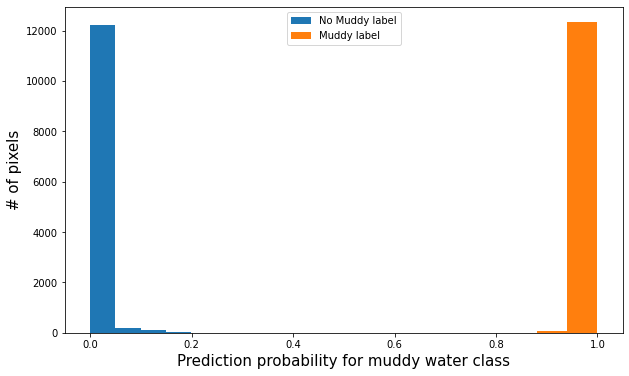

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(y_train_hat[:, 1][y_train==0], bins=10);
ax.hist(y_train_hat[:, 1][y_train==1], bins=10);
ax.set_xlabel('Prediction probability for muddy water class', fontsize=15)
ax.set_ylabel('# of pixels', fontsize=15)
ax.legend(labels=['No Muddy label', 'Muddy label'], loc='upper center');

# y_train.shape, y_train_hat.shape

In [36]:
fig.savefig('/home/AOIs/polyphytos/signal_background_muddy.png', dpi=300, bbox_inches='tight')

In [55]:
importances = list(model.feature_importances_)

In [60]:
x_values, feature_list

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
x_values = list(range(len(importances))) # Make a bar chart
ax.bar(x_values, [item*100 for item in importances], orientation='vertical')# Tick labels for x axis
ax.set_xticks(x_values) # Axis labels and title
ax.set_xticklabels(feature_list) # labels
# plt.set_yticks(x_values, feature_list, rotation=45, fontsize=13)# Axis labels and title
plt.ylabel('Importance [%]', fontsize=15);
plt.xlabel('Variable name', fontsize=15);
plt.title('Feature Importances', fontsize=18);
fig.savefig('/home/AOIs/polyphytos/feature_importances.png', dpi=300, bbox_inches='tight')

In [64]:
# Fit model final
model.fit(x, y);

In [65]:
# Save model
joblib.dump(model, '/home/AOIs/polyphytos/rf_model.sav')

['/home/AOIs/polyphytos/rf_model.sav']